# Laser cooling guide

In this notebook I will try to replicate (ans simplify the code) of Rick's lasercooling notebook not just to have a better understanding but hopefully to be able to to improve upon it and to add the necessary adjustments to be able to replicate the date from the experiment here.

In [50]:
import statistics

#Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.stats as st
from scipy.optimize import curve_fit
import pandas as pd
import random
from scipy.optimize import leastsq
from matplotlib import cm as CM
from scipy.stats import norm

This are global paramters and eventhough most of them are constant although some might be a good idea to change

In [51]:
# Global constants
c    = 299792458         # m/s, speed of light
kB   = 1.380649e-23      # J/K. Boltzmann constant
amu  = 1.66053904e-27    # kg, molar mass conversion constant
h    = 6.62607015e-34    # J s,  Planck constant
hbar = h/(2*np.pi)
g    = 9.81              # m/s**2, constant of acceleration due to Earth's gravity

# properties of setup
Labs     =  0.005
Lfront   =  0.197
Lhex     =  0.390
Lback    =  0.127 - 0.04           
Llc      =  0.15
Ldetect  =  0.60
Lsp      =  3.50 - Ldetect - Llc - Lback - Lhex - Lfront

L        = [Lfront-Labs, Lhex, Lback, Llc, Ldetect, Lsp]

# Properties for BaF (or SrF)
#mass = (88 + 19) *amu   
mass = (138 + 19) *amu   
B    = 0.21594802         # rotational constant of BaF in cm-1 (Master Thesis Jeroen Maat)
mu   = 3.170*0.0168       # dipole moment in cm-1/(kv/cm)  (debye * conversionfactor)

Starkfit = [[0 for i in range(7)] for j in range(5)]
Starkfit[0] = [1.99832523,  2.78038613,  1.0962849,  11.2629089,   1.6618291,   0.,  0.,  0.,  0.]   # parameters for N=1,M=0 state of BaF. Which paramters?
Starkfit[1] = [1.99297730e+00, -2.30557413e-06,  6.22563075e-04,  1.66160290e+00,  2.42295526e-01,  2.69430173e+00,  4.12591610e-01]    # parametersfor N=1,M=1 state of BaF  
                          

delta    = 1.e-6          # used for taking derivative of field. > 1.e-4 the results start to deviate.
dt       = 1.e-4          # timestep in the guiding() function; depends on the acceleration. 
                          # 1.e-4 is sufficient for an error less than 10 micron after 5 meters of flight. 

J2wavenr = 1/(100*h*c)    # factor to convert energy in cm-1 to SI



r0hex    = 6.e-3          # inner radius hexapole
phi0hex  = 4.501e3 #4.5e3          # voltage applied to hexapole rods (plus and minus -> the voltage difference between adjacent rods is 2*phi0hex)

wavevector =  2*np.pi/860e-9
gamma      =  1/60e-9

x_laser    =  10#10.e-3      # size laserbeam   
'''
size laserbeam? like what, the width?
'''
v_Doppler  =  0.1         # minimum velocity corresponding to the Doppler temperature in m/s 

s0         =  4.        #12.  # I/I_s
detuning   =  3.2*gamma   # detuning in Hz

xx0      = [0.66e-3,   0,    0.e-3,  0.,   0.,  0., 184.]
dxx      = [0.33e-3,  4.5e-3, 4.5e-3, 0.e-3, 20., 20., 27.]  

#nn = 1000   # number of molecules !100000
#nnsim = 10000   # number of molecules in simulation !100000
ni = 100      # number of voltage steps !200
pi=np.pi

There are basically two main parts of the experiment we want to simulate. The hexapole and the laser cooling. The hexapole part is going to require many more functions because there are more physics happening there (like the Stark effect etc.)

Let's start by simulating the laser cooling alone and let's just see if we can get a force curve.

#First we need to write the fit acceleration function Rick wrote. 
# see eq. 7.1 Metcalf and van der Straten with factor 4500/15000 to get proper acceleration according to simulations of Roman
def ascat(vx,fudgefactor,s0,detuning):
    ascat = fudgefactor*((gamma/2)*(s0/(1 + s0 + (2*(detuning*gamma + wavevector*vx)/gamma)**2))*hbar*wavevector  \
                        -(gamma/2)*(s0/(1 + s0 + (2*(detuning*gamma - wavevector*vx)/gamma)**2))*hbar*wavevector)/mass  
    return ascat
def fitfunction(vx_list,fudgefactor,s0,detuning):
    fit = np.array([0.0 for j in range(len(vx_list))])
    for j in range(len(vx_list)):
        fit[j] = fudgefactor*((gamma/2)*(s0/(1 + s0 + (2*(detuning*gamma + wavevector*vx_list[j])/gamma)**2))*hbar*wavevector  \
                             -(gamma/2)*(s0/(1 + s0 + (2*(detuning*gamma - wavevector*vx_list[j])/gamma)**2))*hbar*wavevector)/mass 
    return fit


What do these equations do? The ascat is a function that fits the laser cooling force given a speed, the fudgefactor, the saturation parameter and the detuning.
The fitfunction is basically the same function as ascat except it works for an array of function and not for a single velocity.
With these functions we should be able to simulate a force curve.

'''
def lasercooling(finish,fudgefactor,s0,detuning,xxs,hit): #xxs represents an array of t,x,y,z,vx,vy,vz
    xxp=xxs
    ti,xi,yi,zi,vxi,vyi,vzi=xxs
    tf,xf,yf,zf,vxf,vyf,vzf=xxp
    nsteps=0
    while((vzi<=vzf<finish) and hit==True):
        if ((abs(xf)<=0.5*x_laser) and (abs(vxf)>0.5*v_Doppler)):
            vxf+=dt*ascat(vxf,fudgefactor,s0,detuning)
        if ((abs(yf)<=0.5*x_laser) and (abs(vyf)>0.5*v_Doppler)):
            vyf +=dt*ascat(vyf,fudgefactor,s0,detuning)
        vzf+=0
        xf+=dt*vxf
        yf+=dt*vyf
        vzf+=dt*vzf
        tf+=dt
        nsteps+=1
    return [np.array([tf,xf,yf,zf,vxf,vyf,vzf]),hit]
'''
    

def lasercooling(endpoint,fudgefactor,s0,detuning,xxs,hit):           #here, xxs is assumed to be 1-D arrays with 7 elems; t,x,y,z,vx,vy,vz
   
    xxp = np.zeros(7)
    for i in range(0,7): xxp[i] = xxs[i]
    nsteps = 0   
    while((xxs[3] <= xxp[3] < endpoint) and hit == True):
        
        if((abs(xxp[1]) <= 0.5*x_laser) and (abs(xxp[4]) > 0.5*v_Doppler)) :
            xxp[4] += dt*ascat(xxp[4],fudgefactor,s0,detuning)     
        if((abs(xxp[2]) <= 0.5*x_laser) and (abs(xxp[5]) > 0.5*v_Doppler)) :
            xxp[5] += dt*ascat(xxp[5],fudgefactor,s0,detuning)
          
        xxp[6] += 0
            
        xxp[1] += dt*xxp[4]
        xxp[2] += dt*xxp[5]
        xxp[3] += dt*xxp[6]
            
        xxp[0] += dt
            
        nsteps += 1
        
    return [xxp,hit]  

#Would be good to know where this function comes from, like phisically
# I mean it's about the Stark shift but I'm nos exactly sure where it comes from

def WStark(E,s):
    
   muoverB  = mu/B     
   WStark   = B*(Starkfit[s][0] + (np.sqrt(Starkfit[s][1]**2 + (Starkfit[s][2]*muoverB*E)**2) - Starkfit[s][1]) \
                                - (np.sqrt(Starkfit[s][3]**2 + (Starkfit[s][4]*muoverB*E)**2) - Starkfit[s][3]) \
                                - (np.sqrt(Starkfit[s][5]**2 + (Starkfit[s][6]*muoverB*E)**2) - Starkfit[s][5]) \
                 ) 
   return WStark 

'''
The following functions are requiered for the hexapole simulation.
'''
def Phihex(x,y,phi0hex,r0hex): 
    r = (x**2+y**2)**(1/2)
    if r > 0:
        if y > 0. :
            theta = np.arccos(x/r) - (10/180)*np.pi
        else :
            theta = -np.arccos(x/r) - (10/180)*np.pi

    phihex = (r/r0hex)**3 * (phi0hex * np.cos(3*theta))   # with a3=3 
    '''They are using equation 26'''
    
    return phihex
def Ehex(x,y,phi0hex,r0hex):    
    Ehex = 1.e-5*np.sqrt(((Phihex(x+delta,y,phi0hex,r0hex)-Phihex(x-delta,y,phi0hex,r0hex))/(2.*delta))**2 \
                        +((Phihex(x,y+delta,phi0hex,r0hex)-Phihex(x,y-delta,phi0hex,r0hex))/(2.*delta))**2)
    
                                  # Gives electric field in cm-1/(kV/cm) (hence the factor 1.e-5)
    return Ehex

def Whex(x,y,phi0hex,r0hex,s):
   E        =  Ehex(x,y,phi0hex,r0hex)  
   Whex     =  WStark(E,s)
   return Whex 

def axhex(x,y,phi0hex,r0hex,s):
    axhex = -(((Whex(x+delta,y,phi0hex,r0hex,s)-Whex(x-delta,y,phi0hex,r0hex,s))/J2wavenr)/(2*delta*mass))
    return axhex

def ayhex(x,y,phi0hex,r0hex,s):
    ayhex = -(((Whex(x,y+delta,phi0hex,r0hex,s)-Whex(x,y-delta,phi0hex,r0hex,s))/J2wavenr)/(2*delta*mass))
    return ayhex    

'''
This function is used to find the optimal paramters for the saturation, detunning
and the fudgefactor. It still needs the leastq function from scipy. 
Check test_acceleration_curve.ipynb
'''
def residual(vars, vx_list,ascat_sim, data, eps_data):
   afit = vars          
   chi  = 0. 
   fit  = fitfunction(vx_list,afit[0],afit[1],afit[2])
   for j in range(len(vx_list)):
       chi +=    ((ascat_sim - fit[j])/1.)**2/float(len(vx_list)) 
#   print(np.sqrt(chi))
#   print(vars)
   return ((ascat_sim-fit) / 1.) 

def phasespaceellipse2D(xx0,dxx):
    # 
    itry = 0
    
    hit = False
    while hit == False and itry < 100:
        xx = np.zeros(7)
        itry += 1
#        print("itry:",itry)
        if itry > 99 :
            print("itry exceeded 100!")    
        xr = np.sqrt(np.random.uniform())            
        theta = np.random.uniform()*2*np.pi  
        '''
        This are the coordinates of the random walk that are been used to simulate the trajectory of the particle.
        Why do we need a random walk to simulate it? Since particles are emitting photons in random directions
        '''
        xx[1] = xx0[1] + 0.5*dxx[1]*xr*np.sin(theta)  # Only x-coordinate. This is the position of the particle
        xx[4] = xx0[4] + 0.5*dxx[4]*xr*np.cos(theta)  #This is the velocity of the particle.

        xr = np.sqrt(np.random.uniform())           
        theta = np.random.uniform()*2*np.pi
        '''
        This lines may seem redudant but they're not. They are used to defined the coordinates for the y-axis. If they weren't redefined then x==y would always happpend.
        '''
        xx[2] = xx0[2] + 0.5*dxx[2]*xr*np.sin(theta)  # 
        xx[5] = xx0[5] + 0.5*dxx[5]*xr*np.cos(theta)

        if ((xx[1]-xx0[1])**2 + (xx[2]-xx0[2])**2 < (0.5*dxx[1])**2): #wouldn't we need dxx[2] here two?
            hit = True
    xx[0] = np.random.normal(xx0[0],dxx[0])    
    xx[3] = xx0[3]
    xx[6] = np.random.normal(xx0[6],dxx[6])     
    if(np.random.uniform() > 0.):                            # in N=1; 3/5 in m=1 and 2/5 in m=0; (if > 0.4 then s=0)
       s = 0
    else: 
       s = 1      
#        xr = np.sqrt(np.random.uniform())            
#        theta = np.random.uniform()*2*np.pi
#    
#        xx[3] = xx0[3] + 0.5*dxx[3]*xr*np.sin(theta)  # Only z-coordinate
#        xx[6] = xx0[6] + 0.5*dxx[6]*xr*np.cos(theta) 
    return [xx,s,hit]



def freeflight(endpoint,xxs,hit):
    nteps=0
    xxp=xxs
    ti,xi,yi,zi,vxi,vyi,vzi=xxs
    tf,xf,yf,zf,vxf,vyf,vzf=xxp
    while (zi<=zf<endpoint and hit ==True):
        xf+=vxf*(endpoint-zi)/vzf
        yf+=vyf*(endpoint-zi)/vzf
        zf=endpoint
        #This function will run for only one iteration. There might be a better way to do it
        tf+=(endpoint-zi)/vzf
        nteps+=1
    return [np.array([tf,xf,yf,zf,vxf,vyf,vzf]),hit]
'''
freeflight will always return a hit==True because it never changes the variable.
'''
def hexapole(endpoint,phi0hex,r0hex,xxs,s,hit): #xxs is a 1-D arrray with 7 elements.
    nteps=0
    xxp=xxs
    ti,xi,yi,zi,vxi,vyi,vzi=xxs
    tf,xf,yf,zf,vxf,vyf,vzf=xxp
    while((zi<=zf<endpoint) and hit==True):
        if -phi0hex<Phihex(xf,yf,phi0hex,r0hex)<phi0hex:
            vxf+=dt*axhex(xf,yf,phi0hex,r0hex,s)
            vyf+=dt*ayhex(xf,yf,phi0hex,r0hex,s)
            vzf+=0
            xf+=dt*vxf
            yf+=dt*vyf
            zf+=dt*vzf
            tf+=dt
            nteps+=1
        else:
            hit=False
            break
    return [np.array([tf,xf,yf,zf,vxf,vyf,vzf]),hit]



In [52]:
def WStark(E,s):
    
   muoverB  = mu/B     
   WStark   = B*(Starkfit[s][0] + (np.sqrt(Starkfit[s][1]**2 + (Starkfit[s][2]*muoverB*E)**2) - Starkfit[s][1]) \
                                - (np.sqrt(Starkfit[s][3]**2 + (Starkfit[s][4]*muoverB*E)**2) - Starkfit[s][3]) \
                                - (np.sqrt(Starkfit[s][5]**2 + (Starkfit[s][6]*muoverB*E)**2) - Starkfit[s][5]) \
                 ) 
   return WStark 
def Phihex(x,y,phi0hex,r0hex): 
    r = (x**2+y**2)**(1/2)
    if r > 0:
        if y > 0. :
            theta = np.arccos(x/r) - (10/180)*np.pi
        else :
            theta = -np.arccos(x/r) - (10/180)*np.pi

    phihex = (r/r0hex)**3 * (phi0hex * np.cos(3*theta))   # with a3=3 
    '''They are using equation 26'''
    
    return phihex

def Ehex(x,y,phi0hex,r0hex):    
    Ehex = 1.e-5*np.sqrt(((Phihex(x+delta,y,phi0hex,r0hex)-Phihex(x-delta,y,phi0hex,r0hex))/(2.*delta))**2 \
                        +((Phihex(x,y+delta,phi0hex,r0hex)-Phihex(x,y-delta,phi0hex,r0hex))/(2.*delta))**2)
    
                                  # Gives electric field in cm-1/(kV/cm) (hence the factor 1.e-5)
    return Ehex

def Whex(x,y,phi0hex,r0hex,s):
   E        =  Ehex(x,y,phi0hex,r0hex)  
   Whex     =  WStark(E,s)
   return Whex 

def axhex(x,y,phi0hex,r0hex,s):
    axhex = -(((Whex(x+delta,y,phi0hex,r0hex,s)-Whex(x-delta,y,phi0hex,r0hex,s))/J2wavenr)/(2*delta*mass))
    return axhex

def ayhex(x,y,phi0hex,r0hex,s):
    ayhex = -(((Whex(x,y+delta,phi0hex,r0hex,s)-Whex(x,y-delta,phi0hex,r0hex,s))/J2wavenr)/(2*delta*mass))
    return ayhex      

# see eq. 7.1 Metcalf and van der Straten with factor 4500/15000 to get proper acceleration according to simulations of Roman
def ascat(vx,fudgefactor,s0,detuning):
    ascat = fudgefactor*((gamma/2)*(s0/(1 + s0 + (2*(detuning*gamma + wavevector*vx)/gamma)**2))*hbar*wavevector  \
                        -(gamma/2)*(s0/(1 + s0 + (2*(detuning*gamma - wavevector*vx)/gamma)**2))*hbar*wavevector)/mass  
    return ascat
'''
As I understand it, the ascat is some kind of fit for the acceleration.
'''


# see eq. 7.1 Metcalf and van der Straten with factor 4500/15000 to get proper acceleration according to simulations of Roman
def fitfunction(vx_list,fudgefactor,s0,detuning):
    fit = np.array([0.0 for j in range(len(vx_list))])
    for j in range(len(vx_list)):
        fit[j] = fudgefactor*((gamma/2)*(s0/(1 + s0 + (2*(detuning*gamma + wavevector*vx_list[j])/gamma)**2))*hbar*wavevector  \
                             -(gamma/2)*(s0/(1 + s0 + (2*(detuning*gamma - wavevector*vx_list[j])/gamma)**2))*hbar*wavevector)/mass 
    return fit

'''i.e., ascat and fitfunction are the same, but fitfunction returns a list of accelerations rather than one acceleration'''

'i.e., ascat and fitfunction are the same, but fitfunction returns a list of accelerations rather than one acceleration'

In [53]:
def phasespaceellipse2D(xx0,dxx):
    # 
    itry = 0
    
    hit = False
    while hit == False and itry < 100:
        xx = np.zeros(7)
        itry += 1
#        print("itry:",itry)
        if itry > 99 :
            print("itry exceeded 100!")
               
        xr = np.sqrt(np.random.uniform())            
        theta = np.random.uniform()*2*np.pi  
        '''
        This are the coordinates of the random walk that are been used to simulate the trajectory of the particle.
        Why do we need a random walk to simulate it? Since particles are emitting photons in random directions
        '''
        
        xx[1] = xx0[1] + 0.5*dxx[1]*xr*np.sin(theta)  # Only x-coordinate. This is the position of the particle
        xx[4] = xx0[4] + 0.5*dxx[4]*xr*np.cos(theta)  #This is the velocity of the particle.

        xr = np.sqrt(np.random.uniform())           
        theta = np.random.uniform()*2*np.pi
        '''
        This lines may seem redudant but they're not. They are used to defined the coordinates for the y-axis. If they weren't redefined then x==y would always happpend.
        '''

        xx[2] = xx0[2] + 0.5*dxx[2]*xr*np.sin(theta)  # 
        xx[5] = xx0[5] + 0.5*dxx[5]*xr*np.cos(theta)

        if ((xx[1]-xx0[1])**2 + (xx[2]-xx0[2])**2 < (0.5*dxx[1])**2): #wouldn't we need dxx[2] here two?
            hit = True
    
    xx[0] = np.random.normal(xx0[0],dxx[0])    
    xx[3] = xx0[3]
    xx[6] = np.random.normal(xx0[6],dxx[6])     
    
    if(np.random.uniform() > 0.):                            # in N=1; 3/5 in m=1 and 2/5 in m=0; (if > 0.4 then s=0)
       s = 0
    else: 
       s = 1      
#    
#        xr = np.sqrt(np.random.uniform())            
#        theta = np.random.uniform()*2*np.pi
#    
#        xx[3] = xx0[3] + 0.5*dxx[3]*xr*np.sin(theta)  # Only z-coordinate
#        xx[6] = xx0[6] + 0.5*dxx[6]*xr*np.cos(theta) 
#            
    
    return [xx,s,hit]

'''
This funcition runs until it finds a point it can work with i.e it keeps redefining xx
'''

'\nThis funcition runs until it finds a point it can work with i.e it keeps redefining xx\n'

In [54]:
def freeflight(endpoint,xxs,hit):                         #here, xxs is assumed to be 1-D arrays with 7 elems; t,x,y,z,vx,vy,vz

    xxp = np.zeros(7)
    nsteps=0
    for i in range(0,7): xxp[i] = xxs[i]  
  
    while(xxs[3] <= xxp[3] < endpoint and hit == True):
            
        xxp[1] += xxp[4]*(endpoint-xxs[3])/xxp[6]
        xxp[2] += xxp[5]*(endpoint-xxs[3])/xxp[6]
        xxp[3]  = endpoint
        #Wouldn't this only run for one iteration?
        
        xxp[0] += (endpoint-xxs[3])/xxp[6]
        
        nsteps     += 1
        #print(nsteps)
    
    return [xxp,hit]     
'''
freeflight will always return a hit==True because it never changes the variable.
'''

def hexapole(endpoint,phi0hex,r0hex,xxs,s,hit):               #here, xxs is assumed to be 1-D arrays with 7 elems; t,x,y,z,vx,vy,vz

    xxp = np.zeros(7)
    for i in range(0,7): xxp[i] = xxs[i]
    nsteps = 0   
    while((xxs[3] <= xxp[3] < endpoint) and hit == True):
        
#        if (xxp[1]**2 + xxp[2]**2) <= r0hex**2:
        if -phi0hex < Phihex(xxp[1],xxp[2],phi0hex,r0hex) < phi0hex :
        
            xxp[4] += dt*axhex(xxp[1],xxp[2],phi0hex,r0hex,s)  
            '''
            Here I think that axhex is the function that changes the trajectory of the particle (an also ayhex)
            '''
            xxp[5] += dt*ayhex(xxp[1],xxp[2],phi0hex,r0hex,s) 
            xxp[6] += 0
            
            xxp[1] += dt*xxp[4]
            xxp[2] += dt*xxp[5]
            xxp[3] += dt*xxp[6]
            
            xxp[0] += dt
            
            nsteps += 1
            
        else:                                               # molecule has hit an electrode. Stop calculation.
            hit = False
            break
    
    return [xxp,hit]     

def lasercooling(endpoint,fudgefactor,s0,detuning,xxs,hit):           #here, xxs is assumed to be 1-D arrays with 7 elems; t,x,y,z,vx,vy,vz
   
    xxp = np.zeros(7)
    for i in range(0,7): xxp[i] = xxs[i]
    nsteps = 0   
    while((xxs[3] <= xxp[3] < endpoint) and hit == True):
        
        if((abs(xxp[1]) <= 0.5*x_laser) and (abs(xxp[4]) > 0.5*v_Doppler)) :
            xxp[4] += dt*ascat(xxp[4],fudgefactor,s0,detuning)     
        if((abs(xxp[2]) <= 0.5*x_laser) and (abs(xxp[5]) > 0.5*v_Doppler)) :
            xxp[5] += dt*ascat(xxp[5],fudgefactor,s0,detuning)
          
        xxp[6] += 0
            
        xxp[1] += dt*xxp[4]
        xxp[2] += dt*xxp[5]
        xxp[3] += dt*xxp[6]
            
        xxp[0] += dt
            
        nsteps += 1
        
    return [xxp,hit]  

Trajectories

In [55]:
def trajectory_simulation(initial_pos,nn,nj,ff,s0,detun,lc = True,hex = True):
    z_position=[]
    x_positiion=[]
    y_position=[]
    vx=[]
    vy=[]
    vz=[]
    ax=[]
    ay=[]
    xx=np.zeros(7)

#nn number of molecules
#nj number of points in each stage of the trajectory (counting only hexapole and laser cooling)
    time = datetime.datetime.now().time()
    print("started at:",time)
    for i in range(0,nn):
        tempz=[]
        tempx=[]
        tempy=[]
        tempvx=[]
        tempvy=[]
        tempax=[]
        tempay=[]
        [xx,s,hit]=initial_pos[i]#How are xx0 and dxx really defined?
        tempz.append(xx[3])
        tempx.append(xx[1])
        tempy.append(xx[2])
        tempvx.append(xx[4])
        tempvy.append(xx[5])
        tempax.append(0.)
        tempay.append(0.)
        [xx,hit]=freeflight(L[0],xx,hit)
        if hit:
            tempz.append(xx[3])
            tempx.append(xx[1])
            tempy.append(xx[2])
            tempvx.append(xx[4])
            tempvy.append(xx[5])
            tempax.append(0.)
            tempay.append(0.)
        if L[1]>0:
            for j in range(nj):
                [xx,hit]=hexapole(L[0]+L[1]*float(j)/float(nj-1),phi0hex,r0hex,xx,s,hit)
                if hit:
                    tempz.append(xx[3])
                    tempx.append(xx[1])
                    tempy.append(xx[2])
                    tempvx.append(xx[4])
                    tempvy.append(xx[5])
                    tempax.append(axhex(xx[4],xx[5],phi0hex,r0hex,s))
                    tempay.append((ayhex(xx[4],xx[5],phi0hex,r0hex,s)))
        tempz.append(xx[3])
        tempx.append(xx[1])
        tempy.append(xx[2])
        tempvx.append(xx[4])
        tempvy.append(xx[5])
        tempax.append(0.)
        tempay.append(0.)
        [xx,hit]=freeflight(L[0]+L[1]+L[2],xx,hit)
        if hit:
            tempz.append(xx[3])
            tempx.append(xx[1])
            tempy.append(xx[2])
            tempvx.append(xx[4])
            tempvy.append(xx[5])
            tempax.append(0.)
            tempay.append(0.)
        if L[1]>0:
            for j in range(nj):
                if lc:
                    [xx,hit]=lasercooling(L[0]+L[1]+L[2]+L[3]*float(j)/float(nj-1),ff,s0,detun,xx,hit)
                    #print('cooling')

                    if hit:
                        tempz.append(xx[3])
                        tempx.append(xx[1])
                        tempy.append(xx[2])
                        tempvx.append(xx[4])
                        tempvy.append(xx[5])
                        tempax.append(ascat(xx[4],ff,s0,detun))
                        tempay.append(ascat(xx[5],ff,s0,detun))

                else:
                    [xx,hit]=freeflight(L[0]+L[1]+L[2]+L[3]*float(j)/float(nj-1),xx,hit)
                    #print('not cooling')
                    if hit:
                        tempz.append(xx[3])
                        tempx.append(xx[1])
                        tempy.append(xx[2])
                        tempvx.append(xx[4])
                        tempvy.append(xx[5])
                        tempax.append(0)
                        tempay.append(0)
                    
                    
        tempz.append(xx[3])
        tempx.append(xx[1])
        tempy.append(xx[2])
        tempvx.append(xx[4])
        tempvy.append(xx[5])
        tempax.append(0.)
        tempay.append(0.)
        [xx,hit]=freeflight(L[0]+L[1]+L[2]+L[3]+L[4],xx,hit)
        if hit:
            tempz.append(xx[3])
            tempx.append(xx[1])
            tempy.append(xx[2])
            tempvx.append(xx[4])
            tempvy.append(xx[5])
            tempax.append(0.)
            tempay.append(0.)
        [xx,hit] = freeflight(L[0] + L[1] + L[2] + L[3] + L[4] + L[5], xx, hit) 
        if hit:            
            tempz.append(xx[3])
            tempx.append(xx[1])
            tempy.append(xx[2])
            tempvx.append(xx[4])
            tempvy.append(xx[5])
            tempax.append(0.)
            tempay.append(0.)
        z_position.append(tempz)
        x_positiion.append(tempx)
        y_position.append(tempy)
        vx.append(tempvx)
        vy.append(tempvy)
        ax.append(tempax)
        ay.append(tempay)
    return [x_positiion,y_position,z_position,vx,vy,ax,ay]





In [56]:
def plot_all(xls,yls,zls,vxls,vyls,axls,ayls):
    nn=len(xls)
    for n in range(nn):
        plt.plot(zls[n],xls[n],"b")
    plt.xlabel('z_axis')
    plt.ylabel('x_axis')
    plt.show()

    plt.clf()
    for n in range(nn):
        plt.plot(zls[n],xls[n],"b")
        plt.xlim(L[0]+L[1]+L[2],L[0]+L[1]+L[2]+L[3])
    plt.xlabel('z_axis')
    plt.ylabel('x_axis')
    plt.show()
    plt.clf()
    for n in range(nn):
        plt.plot(zls[n],vxls[n],"b")
    plt.xlabel('z_axis')
    plt.ylabel('vx_axis')
    plt.show()

    plt.clf()


In [57]:

nn=200
nj=10
initial=[phasespaceellipse2D(xx0,dxx) for i in range(nn)]

started at: 10:30:18.524415


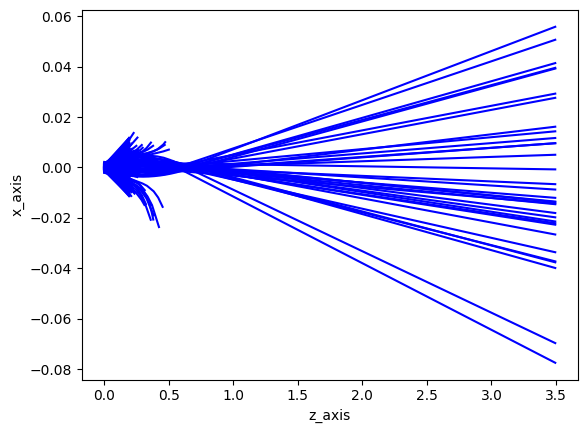

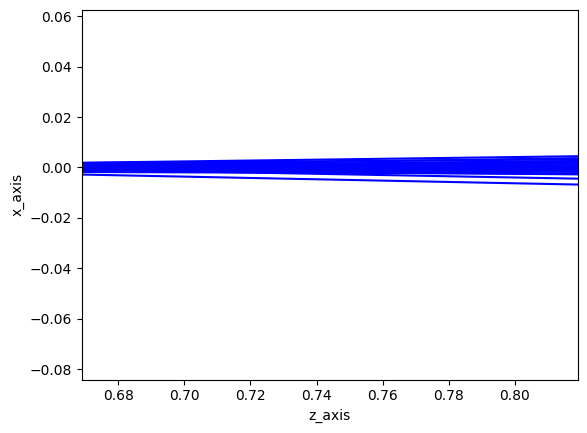

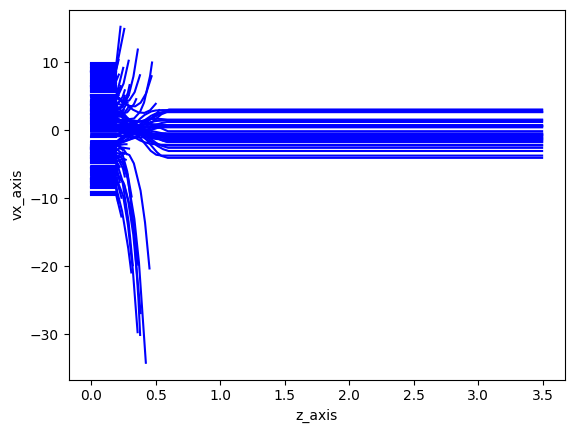

<Figure size 640x480 with 0 Axes>

In [58]:
fudgefactor,s00,detuning=1/3,4,-53333333.33333334
xlist,ylist,zlist,vx,vy,ax,ay=trajectory_simulation(initial,nn,nj,ff=fudgefactor,s0=s00,detun=detuning,lc=True)
plot_all(xlist,ylist,zlist,vx,vy,ax,ay)


Now I'm going to do a function that takes the x,y,z positions as a parameter and makes a distribution of position in the x-y plane. This distribution as related to the number of particles in each point of the x-y plane.

In [59]:
def xy_distribution(xpoints,ypoints,zpoints):
    #First we want the x and y points that are at a distances z. This
    #distance z is Ldetec
    Lcooling=L[0]+L[1]+L[2]+L[3]+L[4]
    n=len(zpoints)
    x=[]
    y=[]
    z=[]
    for i in range(n):
        if Lcooling in zpoints[i]:
            index=zpoints[i].index(Lcooling)
            x.append(xpoints[i][index])
            y.append(ypoints[i][index])
            z.append(zpoints[i][index])
    return x,y,z

33 33 33


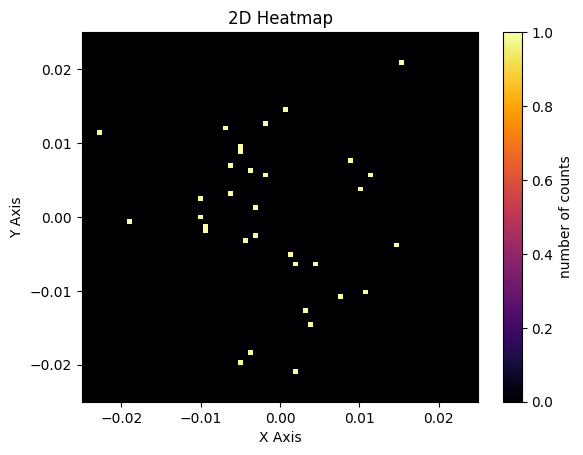

In [60]:
xcooling,ycooling,zcooling=xy_distribution(xlist,ylist,zlist)
print(len(xcooling),len(ycooling),len(zcooling))
#x_edges = np.linspace(min(xcooling), max(xcooling), num=1000)
#y_edges = np.linspace(min(ycooling), max(ycooling), num=1000)
x_edges=np.linspace(-0.025,0.025,80)
y_edges=np.linspace(-0.025,0.025,80)
H, xedges, yedges = np.histogram2d(xcooling, ycooling, bins=[x_edges, y_edges])

fig=plt.figure()
axs=fig.add_subplot(111)

pos=plt.imshow(H.T, origin='lower', aspect='auto', cmap='inferno',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='number of counts')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('2D Heatmap')
plt.show()


-0.02259722538397127 0.015359021813766447


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 2., 0., 1., 1., 1., 1., 2., 1., 3., 4., 1.,
        3., 2., 3., 2., 1., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-0.1  , -0.098, -0.096, -0.094, -0.092, -0.09 , -0.088, -0.086,
        -0.084, -0.082, -0.08 , -0.078, -0.076, -0.074, -0.072, -0.07 ,
        -0.068, -0.066, -0.064, -0.062, -0.06 , -0.058, -0.056, -0.054,
        -0.052, -0.05 , -0.048, -0.046, -0.044, -0.042, -0.04 , -0.038,
        -0.036, -0.034, -0.032, -0.03 , -0.028, -0.026, -0.024, -0.022,
        -0.02 , -0.018, -0.016, -0.014, -0.012, -0.01 , -0.008, -0.006,
        -0.004, -0.002,  0.   ,  0.002,  0.004,  0.006,  0.008,  0.01 ,
         0.012,  0.014,  0.016,  0.018,  0.02 

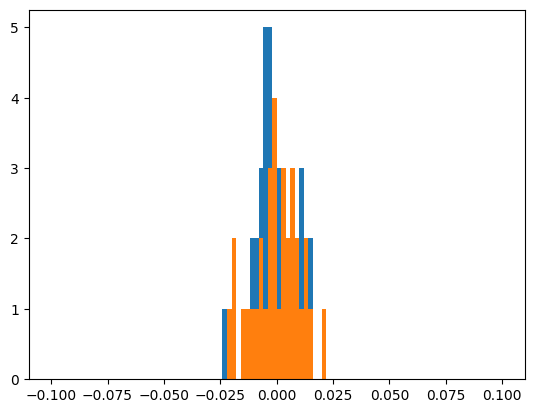

In [61]:
print(min(xcooling), max(xcooling))
plt.hist(xcooling,100,range=(-0.1,0.1))
plt.hist(ycooling,100,range=(-0.1,0.1))

In [2]:
sat='sat'
det='det'
title=sat+det+str(0.7777)
print(title)

satdet0.7777


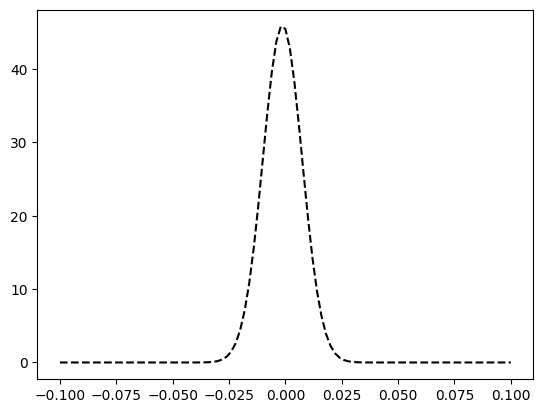

In [62]:
(mu, sigma) = norm.fit(xcooling)
n,bins,patches=plt.hist(xcooling,100,range=(-0.1,0.1))
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
plt.clf()
plt.plot(bins, y, '--', color ='black')
plt.show()